#### Idalia SWAN-Drifter comparison
/proj/usgs-share/Projects/Idalia2023/run1/2dspec  
/proj/usgs-share/Projects/Idalia2023/run1/his  
/proj/usgs-share/Projects/Idalia2023/run1/qck  

In [1]:
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import matplotlib.colors
import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from wavespectra.input.swan import read_swans

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
DATA_FILENAME = 'hurricane_idalia_drifter_data_v2.pickle'

MODEL_DIRECTORY = '/proj/usgs-share/Projects/Idalia2023/run1/2dspec/'


#### Load drifter data
The following adapted from the script used to prepare SWAN model output.
`make_swan_input_idalia.ipynb`

In [2]:
with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    drifters = pickle.load(handle)

drifter_types = ['spotter', 'dwsd', 'microswift']
pfx = ['S', 'D', 'M']
# `drifters` is a python dictionary keyed by drifter type (spotter,
# dwsd, or microswift)
# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter = drifters['spotter']
spotter_ids = list(spotter.keys())

dwsd = drifters['dwsd']
dwsd_ids = list(dwsd.keys())
    
mswift = drifters['microswift']
mswift_ids = list(mswift.keys())

In [3]:
# # Make nicknames for these drifters to conform with the max. 8 char limit in SWAN filesname
# # after adding three characters for a counter (to differentiate the POINTS).
snames=['S025D','S052D','S055D','S061D','S066D','S095D','S101D','S102D','S103D','S164D',
    'D9690','D1280','D3160', 'D3730','D0060','D0070','D0090','D0250','D8160','D9490','D8010',
    'M0029','M0037','M0046','M0048']

icount=0
for dtype in drifter_types:
    drifter_data = drifters[dtype]
    for id in list(drifter_data.keys()):
        print(id, snames[icount])
        icount += 1

SPOT-30025D S025D
SPOT-30052D S052D
SPOT-30055D S055D
SPOT-30061D S061D
SPOT-30066D S066D
SPOT-30095D S095D
SPOT-30101D S101D
SPOT-30102D S102D
SPOT-30103D S103D
SPOT-30164D S164D
300534060649690 D9690
300534060941280 D1280
300534064703160 D3160
300534064703730 D3730
300534064800060 D0060
300534064800070 D0070
300534064800090 D0090
300534064800250 D0250
300534061518160 D8160
300534060949490 D9490
300534061518010 D8010
029 M0029
037 M0037
046 M0046
048 M0048


In [4]:
# Create the SWAN output file names, read SWAN model data, and populate bulk statistics arrays

dt = []
time = []
did = []
lat= []
lon= []
hsmod = []
hsobs = []
tpmod = []
tpobs = []
mdirobs  = []
mdirsobs = []
mdirmod  = []
mdirsmod = []

igood=0
icount=0
for dtype in drifter_types :
    drifter_data = drifters[dtype]
    for id in drifter_data.keys():

        # Some rows have times with other data but no wave info (Spotters only)
        only_waves = drifter_data[id]['energy_density'].notnull()

        ipt = 0 # index must stay below 1000 or file names will be too long
        for index, row in drifter_data[id][only_waves].loc['2023-08-29 1200':'2023-08-30 1300'].iterrows():
           
            fn = "{}{:03d}.spc2d".format( snames[icount], ipt)
            pathname = os.path.join(MODEL_DIRECTORY, fn)

            if Path(pathname).is_file():
                # print(pathname)
                igood+=1
                # drifter obs
                did.append( snames[icount] )
                time.append( index.strftime('%Y%m%d.%H%m') )
                lat.append( row['latitude'] )
                lon.append( row['longitude'] )
                hsobs.append( row['significant_height'] )
                tpobs.append( row['peak_period'] )
                mdirobs.append( row['mean_direction'] )
                mdirsobs.append( row['mean_directional_spread'] )
                # model output
                hsmod.append( np.squeeze( read_swan(pathname).efth.spec.hs().values ) )
                tpmod.append( np.squeeze( read_swan(pathname).efth.spec.tp().values ) )
                mdirmod.append(  np.squeeze( read_swan(pathname).efth.spec.dpm().values ) )
                mdirsmod.append( np.squeeze( read_swan(pathname).efth.spec.dspr().values ) )

            ipt += 1
            
            
        icount +=1

print(igood)


399


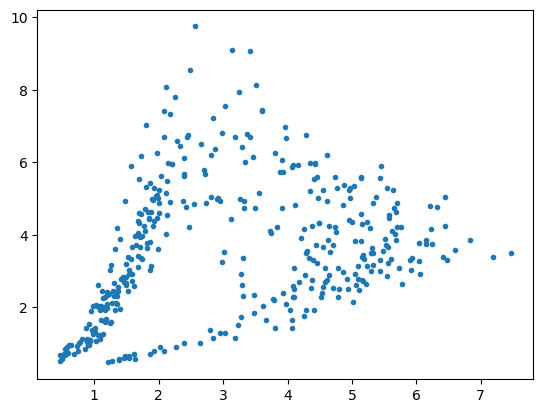

In [5]:
plt.plot(hsobs, hsmod, '.')